# Koronavirus u Hrvatskoj
U ovom projektu će biti prikazano stanje oboljelih od koronavirusa u RH. Strojno čitljive podatke o stanju oboljelih, umrlih i zaraženih sa preuzeo sa stranice https://www.koronavirus.hr/otvoreni-strojno-citljivi-podaci/526. Nakon toga sam analizirao podatke te kreirao grafove koji prikazuju treutno stanje broja oboljelih. zaraženih, aktivnih slučajeva. Također je prikazan i broj zaraženih po dobu i spolu. Na samo kraju aplikacije sam kreirao algoritam koji pomoću linearne regresije pokušava predvidjeti točan broj umrlih od koronavirusa u RH na osnovu tri parametra: broj umrlih u svijet, broj zaraženih u svijetu i broj zaraženih u Hrvatskoj. Za izradu aplikacije korišten je alat Apache Spark koji se koristi u kombinaciji sa pythonom.

# Određivanje putanje i kreiranje Spark konteksa

In [1]:
from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.sql import SparkSession

conf = SparkConf().setAppName("Coronavirus")
conf = (conf.setMaster('local[2]')
        .set('spark.executor.memory', '4G')
        .set('spark.driver.memory', '45G')
        .set('spark.driver.maxResultSize', '10G'))
sc = SparkContext.getOrCreate(conf=conf)
spark = SparkSession(sc)



# Kreiranje SQL konteksta, učitavanje podataka

In [2]:
#Create sql context from spark context
from pyspark.sql.types import *
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)


#Create a data frame from a JSON file
zupanijeDf = sqlContext.read.json("dataset/zupanije.json")
zupanijeDf.show()
zupanijeDf.printSchema()

schema = StructType([
    StructField("Datum", StringType(), True),
    StructField("Zupanija", StringType(), True),
    StructField("dob", IntegerType(), True),
    StructField("spol", StringType(), True),
])

osobeDf = sqlContext.read.json("dataset/osobe.json", schema = schema)
osobeDf.show()
#osobeDf.printSchema()

schema = StructType([
    StructField("Datum", StringType(), True),
    StructField("IzlijeceniHrvatska", IntegerType(), True),
    StructField("IzlijeceniSvijet", IntegerType(), True),
    StructField("SlucajeviHrvatska", IntegerType(), True),
    StructField("SlucajeviSvijet", IntegerType(), True),
    StructField("UmrliHrvatska", IntegerType(), True),
    StructField("UmrliSvijet", IntegerType(), True),
])

svijetDf = sqlContext.read.json("dataset/coronavirus.json", schema = schema)
svijetDf.show()
#svijetDf.printSchema()





+--------------------+------------+-----------+--------------+
|            Zupanija|broj_aktivni|broj_umrlih|broj_zarazenih|
+--------------------+------------+-----------+--------------+
|Bjelovarsko-bilog...|         318|         15|           832|
|    Brodsko-posavska|         325|          7|          1189|
|Dubrovačko-neretv...|         386|         16|          1447|
|         Grad Zagreb|        4004|        161|         11346|
|            Istarska|         348|         13|           979|
|          Karlovačka|         329|         15|          1119|
|Koprivničko-križe...|         226|         21|           597|
|Krapinsko-zagorsk...|         620|          7|          1869|
|       Ličko-senjska|         123|         13|           520|
|          Međimurska|         667|          2|          1350|
|   Osječko-baranjska|        1038|         72|          2948|
|   Požeško-slavonska|         124|          3|           694|
|  Primorsko-goranska|         818|         21|        

# Prikaz umrlih, zaraženih i aktivnih slučajeva u RH

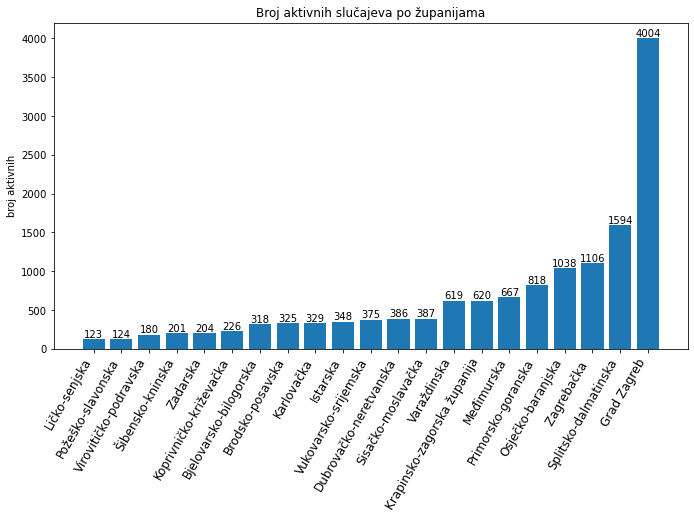

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

zupanije = zupanijeDf.registerTempTable("zupanije")

aktivni = sqlContext.sql("select Zupanija, broj_aktivni from zupanije group by 1,2 order by 2")
aktivni.collect()

zarazeni = sqlContext.sql("select Zupanija, broj_zarazenih from zupanije group by 1,2 order by 2")
zarazeni.collect()

umrlih = sqlContext.sql("select Zupanija, broj_umrlih from zupanije group by 1,2 order by 2")
umrlih.collect()


x1=aktivni.toPandas()["Zupanija"].values.tolist()
y1=aktivni.toPandas()["broj_aktivni"].values.tolist()
z1=zarazeni.toPandas()["broj_zarazenih"].values.tolist()
d1=umrlih.toPandas()["broj_umrlih"].values.tolist()

fig = plt.figure(figsize=(25,6))

ax1 = fig.add_subplot(1,2,1)

rects1 = ax1.bar(x1, y1)
ax1.set_xticklabels(x1, rotation=60, horizontalalignment='right', fontsize='12')
ax1.set_title("Broj aktivnih slučajeva po županijama")
ax1.set_ylabel('broj aktivnih')


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax1.text(rect.get_x() + rect.get_width()/2., height,'%d' % int(height), ha='center', va='bottom')
        
autolabel(rects1)        
plt.savefig("Broj_aktivnih.png", dpi=300, bbox_inches='tight')
plt.show()



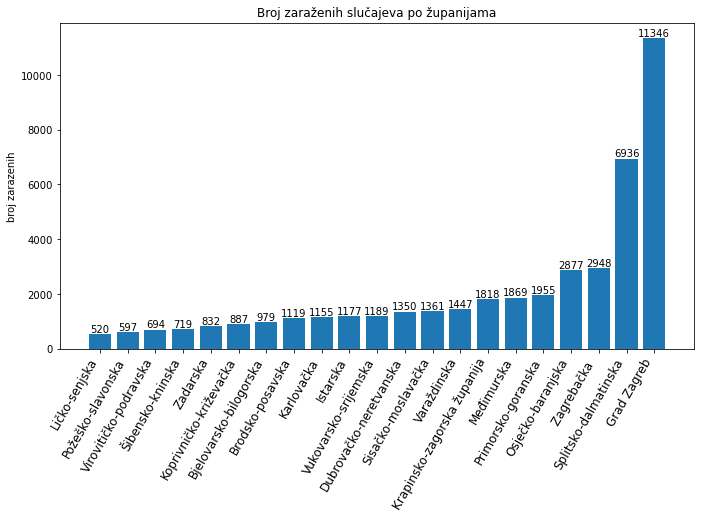

In [4]:
fig = plt.figure(figsize=(25,6))

ax2 = fig.add_subplot(1,2,1)
rects2 = ax2.bar(x1, z1)
ax2.set_xticklabels(x1, rotation=60, horizontalalignment='right', fontsize='12')
ax2.set_title("Broj zaraženih slučajeva po županijama")
ax2.set_ylabel('broj zarazenih')

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax2.text(rect.get_x() + rect.get_width()/2., height,'%d' % int(height), ha='center', va='bottom')
        
autolabel(rects2)        
plt.savefig("Broj_zarazenih.png", dpi=300, bbox_inches='tight')
plt.show()


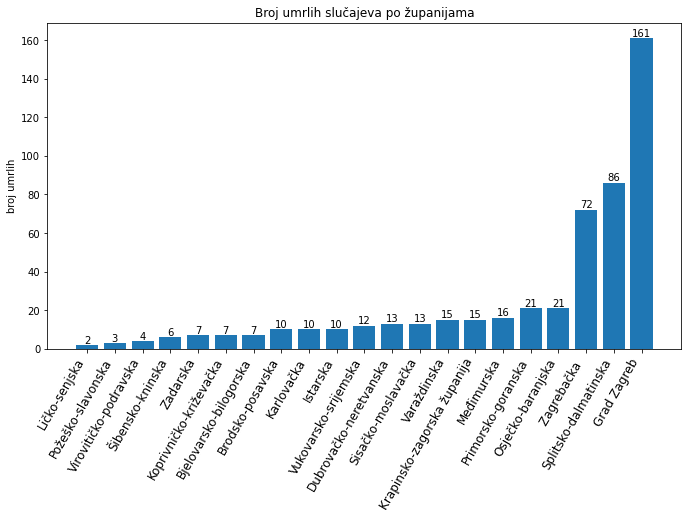

In [5]:
fig1=plt.figure(figsize=(25,6))

ax3 = fig1.add_subplot(1,2,1)

rects3= ax3.bar(x1, d1)
ax3.set_xticklabels(x1, rotation=60, horizontalalignment='right', fontsize='12')
ax3.set_title("Broj umrlih slučajeva po županijama")
ax3.set_ylabel('broj umrlih')

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax3.text(rect.get_x() + rect.get_width()/2., height,'%d' % int(height), ha='center', va='bottom')

autolabel(rects3)
plt.savefig("broj_umrlih.png", dpi=300, bbox_inches='tight')
plt.show()


Text(0.5, 1.0, 'Ukupan broj zaraženih, umrlih i aktivnih slučajeva')

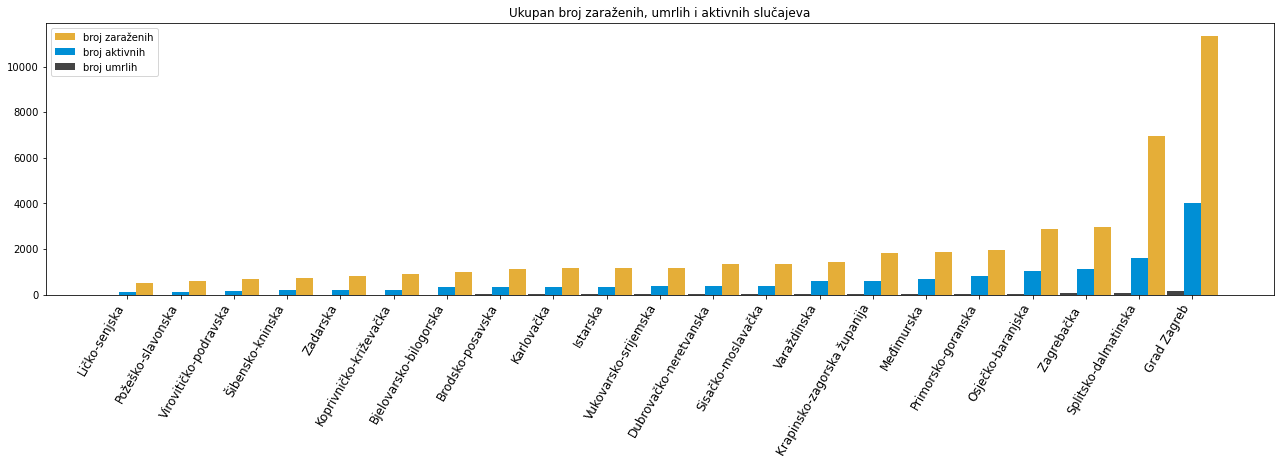

In [6]:
x_indexes = np.arange(len(x1))
width = 0.32

plt.figure(figsize=(22,5))
plt.bar(x_indexes + width, z1, width = width, color="#e5ae38", label="broj zaraženih")
plt.bar(x_indexes, y1, color="#008fd5", width = width,  label="broj aktivnih")
plt.bar(x_indexes - width, d1, width = width, color="#444444", label="broj umrlih")


plt.legend()

plt.savefig("Ukupno.png", dpi=300, bbox_inches='tight')
plt.xticks(ticks=x_indexes, labels=x1,rotation=60, horizontalalignment='right', fontsize='12')

plt.title("Ukupan broj zaraženih, umrlih i aktivnih slučajeva")

#ax3.legend()

# Prikaz oboljelih prema spolu i starosti

<ipython-input-10-25d0b7e1955e>:11: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  plt.pie(values, labels = labels, autopct='%1.1f%%', startangle=140)


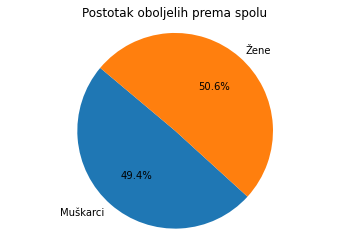

<ipython-input-10-25d0b7e1955e>:27: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  plt.pie(values1, labels = lista, autopct='%1.1f%%', startangle=140)


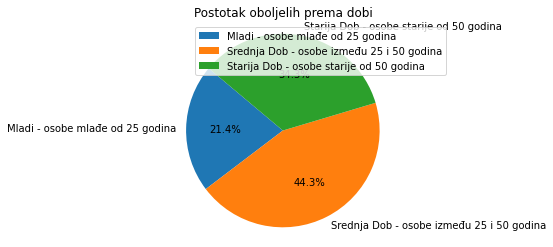

In [10]:
osobe = osobeDf.registerTempTable("osobe")
spolM = sqlContext.sql("select count(spol) as Muski from osobe where spol = 'M'")
spolZ = sqlContext.sql("select count(spol) as Zene from osobe where spol = 'Ž'")

muski = spolM.toPandas()["Muski"].values.tolist()
zene= spolZ.toPandas()["Zene"].values.tolist()

#Pie
labels = "Muškarci", "Žene"
values = [muski,zene]
plt.pie(values, labels = labels, autopct='%1.1f%%', startangle=140)
plt.title("Postotak oboljelih prema spolu")
plt.axis('equal')
plt.savefig("broj_oboljelih prema spolu.png", dpi=300, bbox_inches='tight')
plt.show()

mladi = sqlContext.sql("select count(dob) as Mladi from osobe where dob >= 1995 ")
srednjadob = sqlContext.sql("select count(dob) as SrednjaDob from osobe where dob between 1969 and 1994")
stari = sqlContext.sql("select count(dob) as Stari from osobe where dob <= 1970 ")

mlad = mladi.toPandas()["Mladi"].values.tolist()
srednji = srednjadob.toPandas()["SrednjaDob"].values.tolist()
star = stari.toPandas()["Stari"].values.tolist()

lista = "Mladi - osobe mlađe od 25 godina", "Srednja Dob - osobe između 25 i 50 godina", "Starija Dob - osobe starije od 50 godina"
values1 = [mlad,srednji,star]
plt.pie(values1, labels = lista, autopct='%1.1f%%', startangle=140)
plt.title("Postotak oboljelih prema dobi")
plt.axis('equal')
plt.savefig("broj_oboljelih_prema_dobi.png", dpi=300, bbox_inches='tight')
plt.legend()
plt.show()

# Predikcija broja umrlih u RH pomoću linearne regresije

In [8]:
from pyspark.sql.functions import col, when, to_date
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler

coronaSvijet = svijetDf.registerTempTable("coronavirus")
data = sqlContext.sql("select IzlijeceniHrvatska, IzlijeceniSvijet, SlucajeviHrvatska, SlucajeviSvijet, UmrliHrvatska, UmrliSvijet from coronavirus where SlucajeviSvijet > 0 order by 4")
data.collect()
data.show(50)

#divide data, 85% for training, 15% for testing
dividedData = data.randomSplit([0.9, 0.1]) 
trainingData = dividedData[0] #index 0 = data training
testingData = dividedData[1] #index 1 = data testing
train_rows = trainingData.count()
test_rows = testingData.count()
print ("Training data rows:", train_rows, "; Testing data rows:", test_rows)

#define an assembler
assembler = VectorAssembler(inputCols = [
    "IzlijeceniHrvatska","IzlijeceniSvijet",
    "SlucajeviHrvatska", "SlucajeviSvijet", 
    "UmrliHrvatska","UmrliSvijet"], outputCol="varijable")
#change our features into one column using our defined assembler
trainingDataFinal = assembler.transform(trainingData).select(
    col("varijable"), (col("UmrliHrvatska").cast("Int").alias("UmrliHrvatska")))
trainingDataFinal.show(truncate=False , n=50)


#call Spark linear regression we import before
algoritma = LinearRegression(
    labelCol="UmrliHrvatska",featuresCol="varijable", 
    maxIter=10, regParam=0.3)
#train the model
model = algoritma.fit(trainingDataFinal)
print ("Regression model is trained!")

#just like what we did before in the training data
testingDataFinal = assembler.transform(
    testingData).select(
    col("varijable"), (col("UmrliHrvatska")).cast("Int").alias("UmrlihStvarno"))
testingDataFinal.show(truncate=False, n=10)

#predict testing data using our model
prediction = model.transform(testingDataFinal)
#show some prediction results
prediction.show(100)

#import evaluator module for regression
from pyspark.ml.evaluation import RegressionEvaluator

#define our evaluator
evaluator = RegressionEvaluator(
    labelCol="UmrlihStvarno", predictionCol="prediction", metricName="r2")
#calculate R2 of our trained model
r2 = evaluator.evaluate(prediction)
print ("R2:", r2)



+------------------+----------------+-----------------+---------------+-------------+-----------+
|IzlijeceniHrvatska|IzlijeceniSvijet|SlucajeviHrvatska|SlucajeviSvijet|UmrliHrvatska|UmrliSvijet|
+------------------+----------------+-----------------+---------------+-------------+-----------+
|                 1|           70727|               32|         139016|            0|       5116|
|                 2|           72533|               37|         145682|            0|       5436|
|                 3|           75937|               49|         156760|            0|       6455|
|                 4|           77868|               57|         175696|            0|       6715|
|                 5|           80874|               69|         189683|            0|       7513|
|                 5|           84383|               89|         217539|            0|       8933|
|                 5|           85769|              105|         219894|            0|       8979|
|                 5|

Regression model is trained!
+----------------------------------------------------+-------------+
|varijable                                           |UmrlihStvarno|
+----------------------------------------------------+-------------+
|[5.0,84383.0,89.0,217539.0,0.0,8933.0]              |0            |
|[16.0,103748.0,382.0,396211.0,0.0,17260.0]          |0            |
|[22.0,119732.0,495.0,492250.0,3.0,22180.0]          |3            |
|[1034.0,811777.0,2016.0,2846536.0,54.0,197859.0]    |54           |
|[1166.0,894759.0,2039.0,3018203.0,59.0,207733.0]    |59           |
|[1808.0,1537301.0,2207.0,4274648.0,91.0,287670.0]   |91           |
|[2063.0,2675408.0,2246.0,6052421.0,103.0,367288.0]  |103          |
|[2142.0,4559057.0,2280.0,8608595.0,107.0,456955.0]  |107          |
|[2142.0,4961937.0,2366.0,9218408.0,107.0,474960.0]  |107          |
|[2929.0,8492244.0,4253.0,1.4224334E7,120.0,600159.0]|120          |
+----------------------------------------------------+-------------+
only 